<!--
---
title: "Classification"
author: "Madhura Killedar"
keypoints:
- Classification attempts to predict the class to which a particular observation belongs
- Scikit-learn has tons of classifier options
objectives: Learn how to build and evaluate classifiers
questions: How to classify?
source: ipynb
start: 0
teaching: 30
exercises: 0
---
-->

## Classification

## What is a classifier?

A classifier is some kind of rule / black box / widget that you can feed a new observation/data/record and it will decide whether or not it is part of a given class. E.g. below, we are classifying the animals to be either *cat* or *not cat*.

![A classifier for cats and not cats]("../fig/50-CatNotCat.jpg")

You can have classifiers for anything you can have a yes/no answer to, e.g.

- Is this a cat? 🐱
- Do these test results indicate cancer? 🚑
- Is this email spam or not spam? 📧

You can also have classifiers that categorise things into multiple (more than two) categories e.g.

- Which animal is this, out of the 12 animals I have trained my model on? 🐱
- Do these test results indicate {none, stage 1, stage 2, stage 3, stage 4} cancer? 🚑
- Is this email important, not important but not spam, or spam? 📧

It is clear that in some of these examples we are more concerned with being wrong in one direction than the other, e.g. it's better to let some spam email through accidentally than to block all of it but also junk important emails from people you know. Likewise, we would prefer our medical tests to err on the side of caution and not give a negative test result to someone who needs treatment. So we will need to adjust a parameter to decide how much we want to trade this off.

## Model evaluation (classification)

For now, let's imagine we have a classifier already. How can we test it to see how good it is?
A good start is a confusion matrix - a table of what test data it labels correctly and incorrectly.

![An demonstration of a confusion matrix for a cat classifier that has labelled 100 animals as cats or not-cats.]("../fig/50-CatConfusion.jpg")

### Confusion Matrix

When applying classification models, we often use a confusion matrix to evaluate certain performance measures. A confusion matrix is simply a matrix that compares "the truth" to the labels generated by your classifier. When we label a cat correctly, we refer to this as a true positive. When we fail to label a cat as a cat, this is called a false negative.  However, if we label something which is not a cat as a cat, this is called a false positive; and of course if we correctly label something which is not a cat, as not a cat, then this is a true negative.

### Some common metrics

#### Accuracy: 
How often does the classifier label examples correctly? Objective: maximize. Example: 

$$\frac{TP+TN}{TP+TN+FP+FN} = \frac{\text{Correctly labelled examples}}{\text{All examples}}=\frac{31+52}{31+52+10+7}=83
\%$$

Accuracy is the opposite of the misclassification rate. So,

$$\text{Misclassification rate} = 1 - \text{Accuracy} = \frac{\text{Incorrectly labelled examples}}{\text{All examples}} $$

#### Precision: 
What fraction of things labelled as a cat were actually cats? Objective: maximize. Example:

$$\frac{TP}{TP+FP} = \frac{\text{Correctly labelled cats}}{\text{All things labelled as cats}}=\frac{31}{31+10}=76\%$$

#### Sensitivity / Recall: 
How often does the classifier label a cat as a cat? Objective: maximize. Example: 

$$\frac{TP}{TP+FN} = \frac{\text{Correctly labelled cats}}{\text{All true cats}}=\frac{31}{31+7}=81\%$$

#### Specificity: 
How often does it label a not-cat as a not-cat? Objective: maximize. Example: 

$$\frac{TN}{TN+FP} = \frac{\text{Correctly labelled not-cats}}{\text{All true not-cats}}=\frac{52}{52+10}=84\%$$

#### F1-score:

This is a commonly used overall measure of classifier performance (but not the only one and not always the best depending upon the problem). It is defined as the harmonic mean of precision and sensitivity;

$$\frac{1}{F_1} = \frac{1}{2}\left(\frac{1}{\text{Precision}}+\frac{1}{\text{Sensitivity}}\right) $$
So that
$$F_1 = 2\cdot\left(\frac{1}{\frac{1}{81\%}+\frac{1}{83\%}}\right) = 82\%$$

#### Mean-square error (MSE)

Define a loss function $L_i = 1$ if the $i$th example is classified incorrectly and $L_i = 0$ if it is classified correctly. If there are $N$ examples in total then the mean-square error is

$$\text{MSE} = \frac{1}{N}\sum_i L_i = \frac{\text{Incorrectly labelled examples}}{\text{All examples}}=\text{Misclassification Rate}$$

Which is actually just the misclassification rate above. 

#### AUC: Area under the curve

A good classifier will have high precision and high specificity, minimizing both false positives and false negatives. In practice, and with an imperfect classifier, you can tune a knob to say which of those two you care more about. There will be some kind of a trade-off between the two.

To capture this balance, we often use a Receiver Operator Characteristic (ROC) curve that plots the false positive rate along the x-axis and the true positive rate along the y-axis, for all possible trade-offs. A line that is diagonal from the lower left corner to the upper right corner represents a random guess at labelling each example. The higher the line is in the upper left-hand corner, the better the classifier in general. AUC computes the area under this curve. For a perfect classifier, AUC = 1, for a random guess, AUC=0.5. Objective: maximize.

![A Receiver Operator Characteristic (ROC) curve, from which the Area Under the Curve (AUC) can be calculated.](../fig/50-CatArea.jpg)


# Wisconsin Diagnostic Breast Cancer Dataset

Today we're going to be classifying patient's biopsy to see whether their breast tumor is malignant or benign. First, a fine needle aspirate (FNA) of a breast mass is taken. Basically they stick a needle in you and take a chunk out then put it under the microscope. It looks like this:

![An example of a Fine Needle Aspiration Biopsy](../fig/50-742_FNA1.jpg)

Features are computed from the digitized image, which describe the characteristics of the cell nuclei present in the image.

## Attribute Information:

1) ID number

2) Diagnosis (M = malignant, B = benign)

3-32) other features

Ten real-valued features are computed for each cell nucleus, each has 
- a *mean* across cells 
- a *standard deviation* across cells and 
- the *worst* value across cells:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)


## Let's Explore our data

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score 
from sklearn import model_selection
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(font_scale = 1.5)

### Load Data

In [3]:
wdbc_raw = pd.read_csv('../data/breast-cancer-wisconsin.csv') # read csv
wdbc = wdbc_raw.copy()

Fix the problem of whitespace in column names by replacing with underscores

In [4]:
print(wdbc.columns)
#wdbc.rename(columns=lambda x: x.strip())
wdbc.columns = wdbc.columns.str.replace(' ', '_', regex=True)
#print(wdbc.columns)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


Recode diagnosis into integers

In [5]:
#wdbc['diagnosis']
#wdbc['diagnosis'].astype("category").cat.codes

### Summary info
Shape of data frame

In [6]:
wdbc.shape

(569, 33)

Look for non-NAs

In [7]:
wdbc.count()

id                         569
diagnosis                  569
radius_mean                569
texture_mean               569
perimeter_mean             569
area_mean                  569
smoothness_mean            569
compactness_mean           569
concavity_mean             569
concave_points_mean        569
symmetry_mean              569
fractal_dimension_mean     569
radius_se                  569
texture_se                 569
perimeter_se               569
area_se                    569
smoothness_se              569
compactness_se             569
concavity_se               569
concave_points_se          569
symmetry_se                569
fractal_dimension_se       569
radius_worst               569
texture_worst              569
perimeter_worst            569
area_worst                 569
smoothness_worst           569
compactness_worst          569
concavity_worst            569
concave_points_worst       569
symmetry_worst             569
fractal_dimension_worst    569
Unnamed:

In [8]:
wdbc.drop(columns='Unnamed:_32', inplace=True)
wdbc.drop(columns='id', inplace=True)
wdbc.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
wdbc.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Explore relationship between variables
Plot mean radius of cell nucleii vs. mean concavity, coloured by diagnosis:

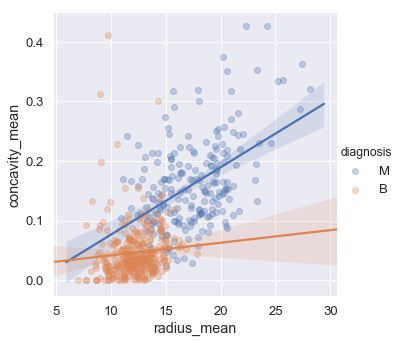

In [23]:
_ = sns.lmplot(x ='radius_mean',
               y = 'concavity_mean',
               data=wdbc, 
               hue='diagnosis',
               scatter_kws={'alpha':0.3})

In [11]:
wdbc.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst

In [12]:
catVars = wdbc.select_dtypes(include = ['object']).columns
numericVars = wdbc.select_dtypes(exclude = ['object']).columns
print(catVars)

Index(['diagnosis'], dtype='object')


If we wanted to look at all possible scatterplot pairs we would do something like:

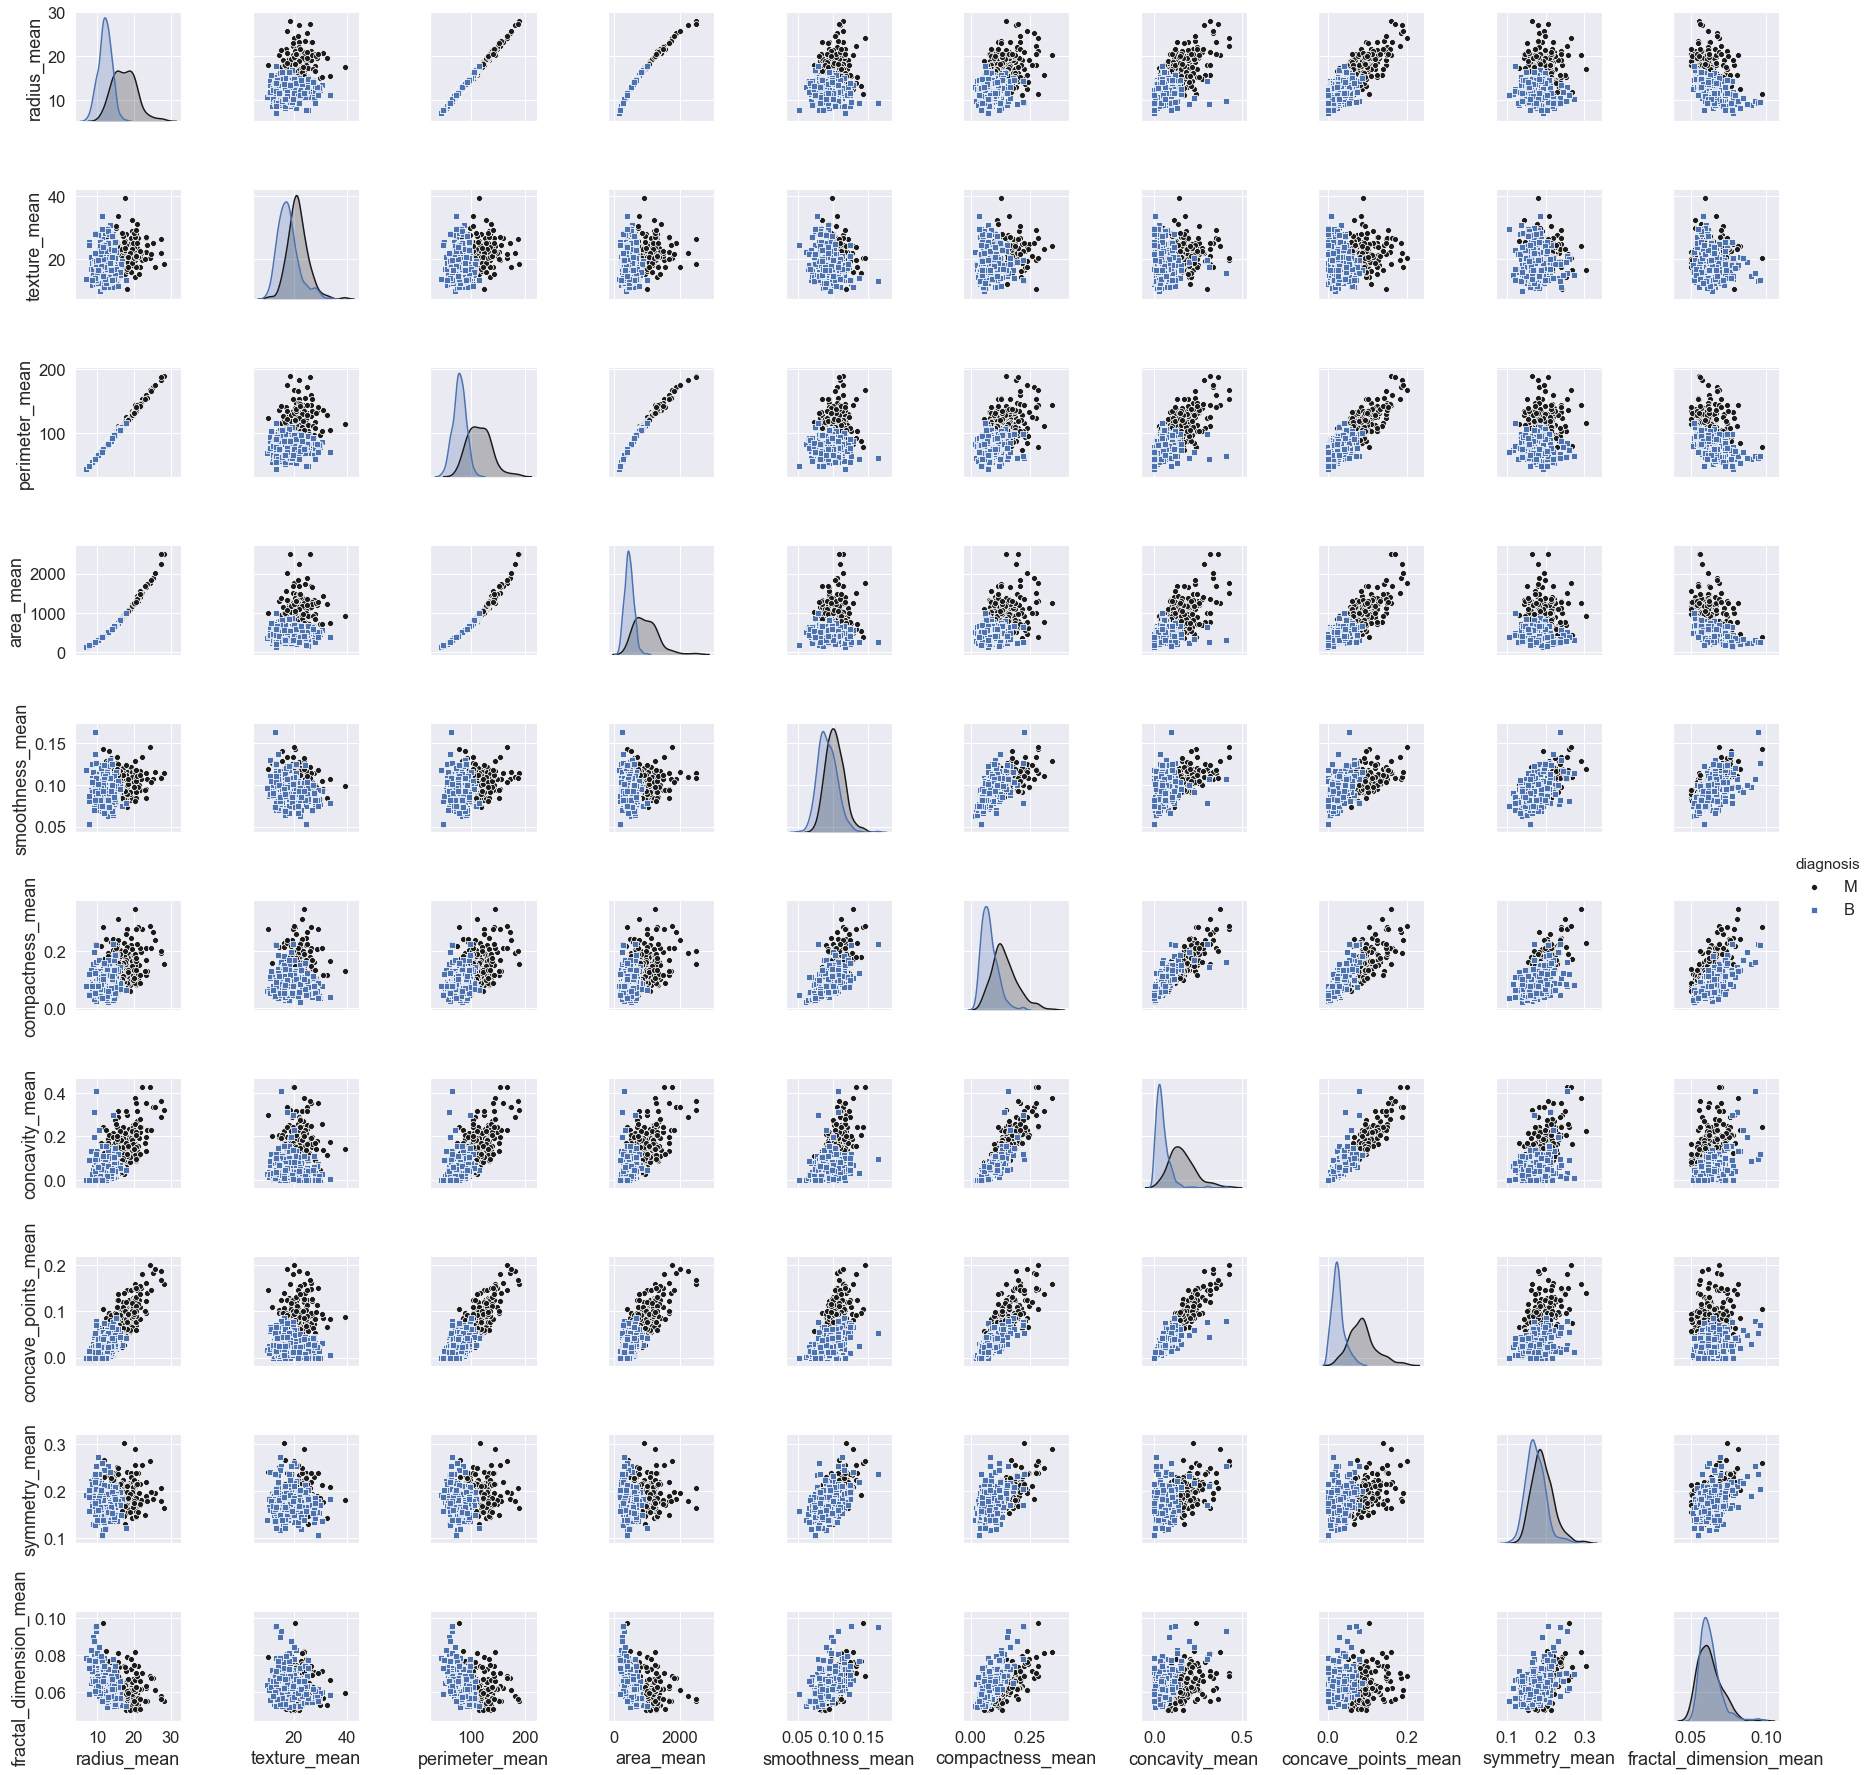

In [13]:
_ = sns.pairplot(data=wdbc,
                 #vars=wdbc.columns[1:10],
                 vars=numericVars[:10],
                 hue='diagnosis',
                 palette={'M':'k','B':'b'},
                 diag_kind='kde',
                 markers=["o", "s"])

In [25]:
wdbc[['radius_mean', 'area_mean', 'perimeter_mean']]
area_rad = wdbc['area_mean']/ wdbc['radius_mean']
per_rad = wdbc['perimeter_mean']/ wdbc['radius_mean']

In [29]:
area_rad.describe()

count    569.000000
mean      43.583393
std       11.160170
min       20.555794
25%       35.892400
50%       41.175584
75%       49.482221
max       91.210795
dtype: float64

In [30]:
per_rad.describe()

count    569.000000
mean       6.489891
std        0.131440
min        6.175258
25%        6.391951
50%        6.468896
75%        6.562342
max        7.120912
dtype: float64

But it's easier to look at a correlation plot:

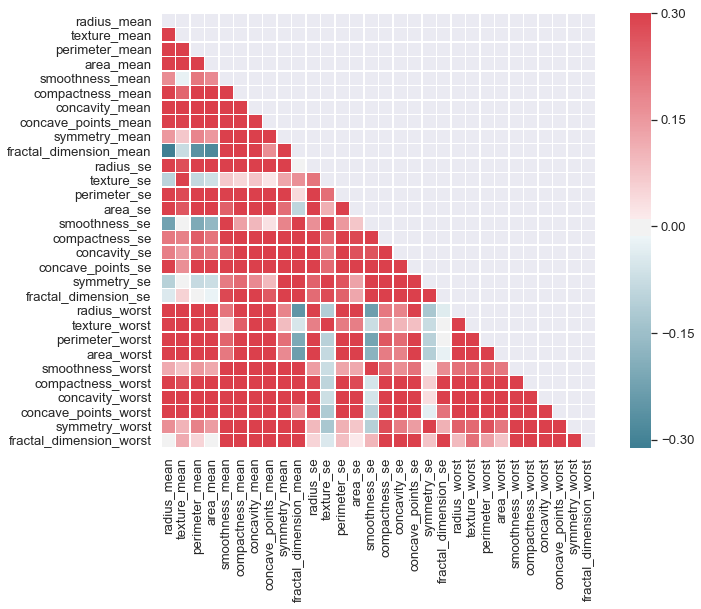

In [14]:
#corr = wdbc[numericVars[1:-1]].corr() # excluding id & Unnamed_32
corr = wdbc.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0., square=True, linewidths=.5)

## Prepare Data

To create a classifier for predicting whether a breast cancer patient's tumor is malignant or benign, we need to train it on some of this dataset, and test on the rest.

In [15]:
# remove id, diagnosis, and Unnamed
predictors = wdbc.columns.values.tolist()
#predictors.remove('id')
predictors.remove('diagnosis')
#predictors.remove('Unnamed:_32')
print(predictors)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']


### Standardize data ranges

In [16]:
#predictors = StandardScaler().fit_transform(predictors)

### Train-Test Split

We're going to split our data into 70% training and 30% testing.

In [17]:
rs = np.random.RandomState(33)

In [18]:
features_train, features_test, outcome_train, outcome_test = model_selection.train_test_split(wdbc[predictors],wdbc['diagnosis'], train_size=0.7, test_size=0.3)

How many examples do we have in the training and testing sets?

In [19]:
features_train.shape

(398, 30)

In [20]:
features_test.shape

(171, 30)

### Standardize data ranges

In [20]:
StSc = StandardScaler()
features_train_sc = StSc.fit_transform(features_train)
features_test_sc  = StSc.transform(features_test)

### Recode outcome

In [53]:
outcome_true = outcome_test.astype("category").cat.codes.values # code into 0's and 1's
# which is 1 which is 0?

# Classifiers

## k-Nearest Neighbours Classifier

This takes the nearest k things and and says what is the majority vote? E.g. in the example below we look at the seven nearest neighbours, 4 of which are cats so we say that the new example is probably a cat as well.

![A way to classify a new example as a cat or not...take the average of the nearest k=7 examples. It's a cat!](../fig/50-CatKNN.jpg)


### Let's Classify!

Train KNN classifier

In [22]:
from sklearn.neighbors import KNeighborsClassifier
cf_knn= KNeighborsClassifier(n_neighbors=6)
fit_knn = cf_knn.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [23]:
outcome_pred_class = cf_knn.predict(features_test_sc)
outcome_pred_prob = cf_knn.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier Diagnostics/evaluation
So how well did the classifier do?

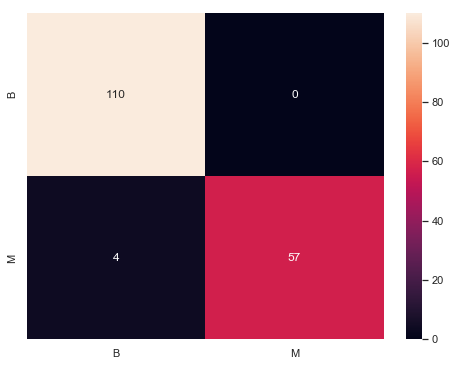

In [24]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
sns.set(rc={'figure.figsize':(8,6)})
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

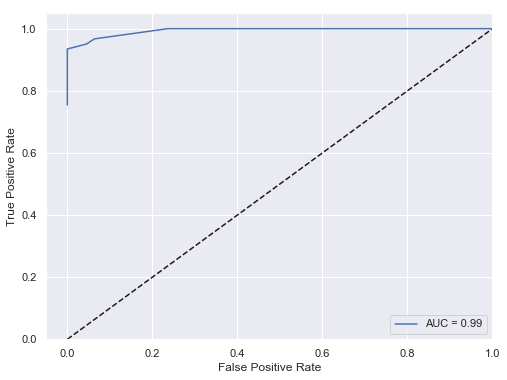

In [25]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)

def plot_ROC(fpr, tpr, AUC):
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = %4.2f'%AUC)
    _ = plt.legend(loc="lower right")
    
plot_ROC(fpr, tpr, AUC)

#### EXERCISE: 
How many neighbours are ideal?

## Naive Bayes Classifier

A Naïve Bayes classifier assumes that each of your columns are independent (uncorrelated with each other). It works out a probability that your example is a cat by counting the fraction of cats that had that value in each column, multiplying the values together and then multiplying again by what fraction of your training examples were cats. This is just writing out bayes rule of conditional probability and simplifying it for independent columns.

$$p(\text{Cat}| x_\text{new})=\frac{p(\text{Cat})p(x_\text{new}|\text{Cat})}{p(\text{Cat})p(x_\text{new}|\text{Cat})+p(\text{Not Cat})p(x_\text{new}|\text{Not Cat})}$$

In practice your columns are probably not independent, but we still use it anyway and it's usually ok, providing we only care about the label and not the probability it spits out.  

Continuous variables have to be somehow turned into discrete variables before you can use this technique, but most algorithms do this for you automatically.


### Let's Classify!
Train Naive Bayes classifier

In [26]:
from sklearn.naive_bayes import GaussianNB
cf_gnb = GaussianNB()
fit_gnb = cf_gnb.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [27]:
outcome_pred_class = cf_gnb.predict(features_test_sc)

### Classifier Diagnostics
So how well did it go?

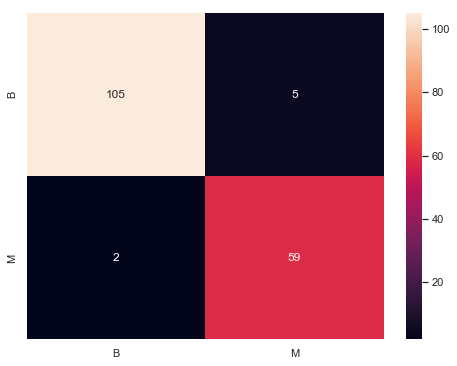

In [28]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
#y_decision = knn.decision_function(features_test)

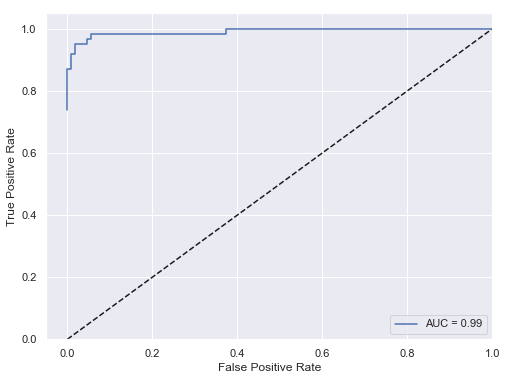

In [29]:
outcome_pred_prob = cf_gnb.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

## Regularized Logistic Classifier

This fits a logistic regression to the probability of receiving a class label of 1 or 0. Regularisation (hopefully) stops it from overfitting. 

### Let's Classify!
Train Regularized Logistic classifier

In [30]:
from sklearn.linear_model import LogisticRegression
cf_rlc = LogisticRegression(random_state=74, solver='lbfgs', multi_class='ovr')
fit_rlc = cf_rlc.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [31]:
outcome_pred_class = cf_rlc.predict(features_test_sc)
outcome_pred_prob = cf_rlc.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier evaluation
So how well did the classifier do?

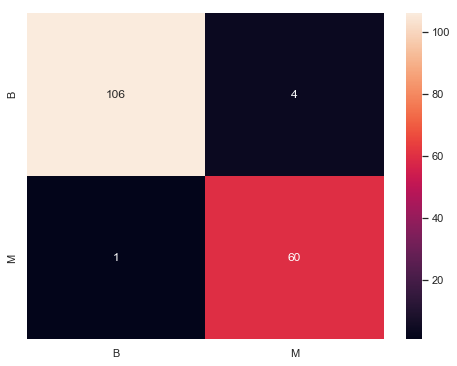

In [32]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

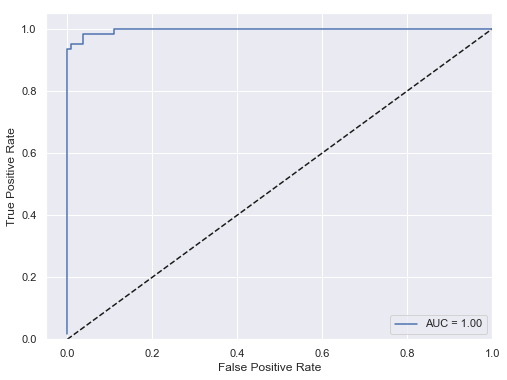

In [33]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

## Decision Trees

A decision tree 🌳 picks the best split in the data greedily for each feature and basically makes a flowchart to follow with a new data point to say what you should classify it as. This makes them easy to understsand, but also usually not very accurate. 

### Let's Classify!
Train Decision Tree classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier
cf_dtc = DecisionTreeClassifier()
fit_dtc = cf_dtc.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [35]:
outcome_pred_class = cf_dtc.predict(features_test_sc)
outcome_pred_prob = cf_dtc.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier evaluation
So how well did the classifier do?

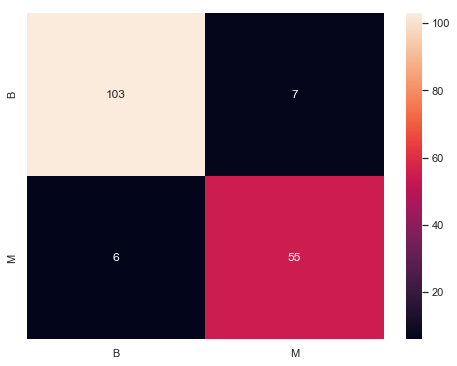

In [36]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

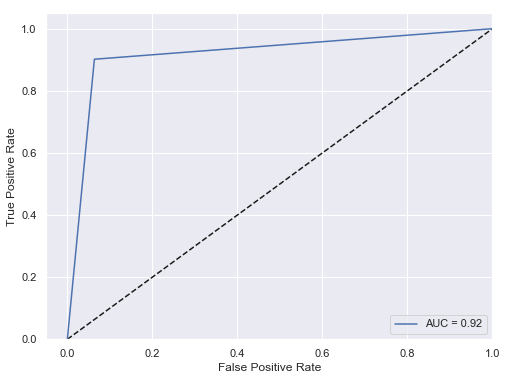

In [37]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

## Random Forest Classifier
A random decision tree is where you make a decision tree but only train it on either (a) a random sample of the available data or (b) a random sample of the available features or (c) both.

A random forest is a whole bunch of these averaged together. 

Turns out these do pretty good and are used all over the place. But because they're the average of so many different models it's hard to get an understanding about it. It's basically a black box that predicts well.

In [38]:
from sklearn.ensemble import RandomForestClassifier
cf_rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
fit_rfc = cf_rfc.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [39]:
outcome_pred_class = cf_rfc.predict(features_test_sc)
outcome_pred_prob = cf_rfc.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier evaluation
So how well did the classifier do?

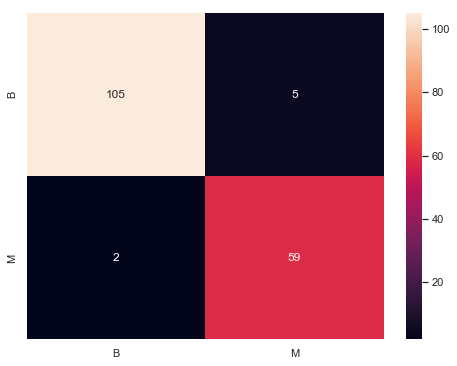

In [40]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

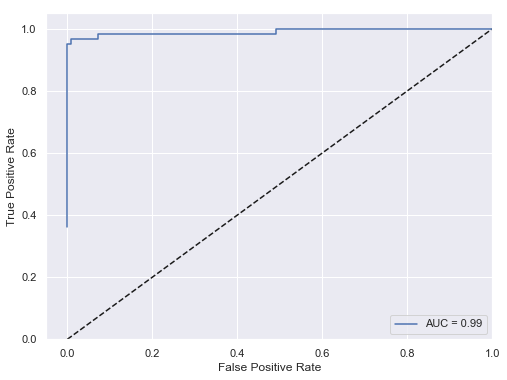

In [41]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

#### EXERCISE: 
What max_depth is ideal?

## Support Vector Machine
A support vector machine tries to find the data points right on the boundary between the two classes (the "support vectors") and then uses them to define a maximum margin boundary.

![A linear Support Vector Machine for Cats](../fig/50-CatSVM.jpg)

### Let's Classify!
Train SVM

In [42]:
from sklearn import svm
cf_svm = svm.LinearSVC()
fit_svm = cf_svm.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [43]:
outcome_pred_class = cf_svm.predict(features_test_sc)

SVM DOESN'T CALCULATE PROBABILITIES!

### Classifier evaluation
So how well did the classifier do?

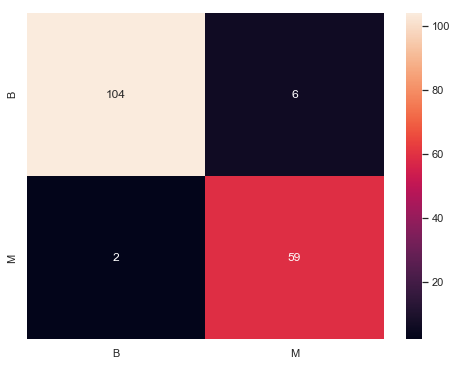

In [44]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

# Compare all the classifiers

In [51]:
evaluations = ['Misclassification rate', 'Sensitivity', 'Specificity', 'AUC']
pretrained_models = {'k Nearest Neighbours':cf_knn, 'Naive Bayes':cf_gnb, 'Regularised Logistic Classifier':cf_rlc, 'Decision Tree':cf_dtc, 'Random Forest':cf_rfc, 'Support Vector Machine':cf_svm}
comparison_stats = pd.DataFrame(index = pretrained_models.keys(), columns=evaluations)
for method, model in pretrained_models.items():
    outcome_pred_class = model.predict(features_test_sc)
    if method in ['Support Vector Machine']:
        AUC = float('nan')
    else:
        outcome_pred_prob = model.predict_proba(features_test_sc)
        outcome_pred_prob1 = [p[1] for p in outcome_pred_prob]
        AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
    conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
    comparison_stats.loc[method,'Misclassification rate']  = 1. - accuracy_score(outcome_test, outcome_pred_class)
    comparison_stats.loc[method,'Sensitivity'] = conf_mat[1,1]/np.sum(conf_mat[1,:])
    comparison_stats.loc[method,'Specificity'] = conf_mat[0,0]/np.sum(conf_mat[0,:])
    comparison_stats.loc[method,'AUC'] = AUC

In [52]:
comparison_stats.round(decimals=3)

,Misclassification rate,Sensitivity,Specificity,AUC
k Nearest Neighbours,0.0233918,0.934426,1,0.993815
Naive Bayes,0.0409357,0.967213,0.954545,0.991207
Regularised Logistic Classifier,0.0292398,0.983607,0.963636,0.99687
Decision Tree,0.0760234,0.901639,0.936364,0.919001
Random Forest,0.0409357,0.967213,0.954545,0.990611
Support Vector Machine,0.0467836,0.967213,0.945455,NaN


What do you think?